In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from datetime import datetime

#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
def ethnicity_multi_labels(x):
    if "ASIAN" in x:
        return "ASIAN"
    elif "AFRICAN" in x:
        return "BLACK"
    elif "HISPANIC" in x:
        return "HISPANIC"
    elif "WHITE" in x:
        return "WHITE"
    elif "NATIVE" in x:
        return "NATIVE"
    else:
        return "OTHER"

def ethnicity_binary_labels(x):
    if "ASIAN" in x or "AFRICAN" in x or "HISPANIC" in x or "NATIVE" in x: 
        return "NON-WHITE"
    elif "WHITE" in x:
        return "WHITE"
    else:
        return "OTHER"

def get_ethnicity_dataset(df, path_out=None):
    df["ETHNICITY_LABEL"] = df["ETHNICITY"].apply(lambda x:ethnicity_binary_labels(x))
    df_ethnicity = df[["ETHNICITY_LABEL","TEXT"]]
    if path_out:
        df_ethnicity.to_csv(path_out,index=False, sep="\t", header=False)
        
    return df_ethnicity

def get_mortality_dataset(df, path_out=None):
    df["EXPIRE"] = df["HOSPITAL_EXPIRE_FLAG"]
    df_mortality = df[["EXPIRE","TEXT"]]
    if path_out:
        df_mortality.to_csv(path_out,index=False, sep="\t", header=False)
    return df_mortality

def get_readmissions_dataset(admissions_df, patients_df, path_out=None):
    data = []
    READMISSION_DELTA = float("inf")
    for _, patient in patients_df.iterrows():
        adm = admissions_df[admissions_df["SUBJECT_ID"] == patient["SUBJECT_ID"]]
        if len(adm) > 1:
            admission_times = list(adm.sort_values("ADMITTIME")["ADMITTIME"])
            for i in range(len(admission_times)-1):
                d1 = admission_times[i]
                d2 = admission_times[i+1]
                d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
                d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
                delta = d2 - d1
                if delta.days < READMISSION_DELTA:
                    data.append([1,patient["TEXT"]])
                    break             
        else:
            data.append([0,patient["TEXT"]])
    readm_df = pd.DataFrame(data, columns=["READMISSION","TEXT"])
    if path_out:
        readm_df.to_csv(path_out,index=False, sep="\t", header=False)    
    return readm_df
    

def extract_patients(mimic_path, sample_size=None, path_out=None):
    all_notes = pd.read_csv(mimic_path+"NOTEEVENTS.CSV.gz")
    all_patients = pd.read_csv(mimic_path+"PATIENTS.CSV.gz")
    all_admissions = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
    #filter relevant columns
    notes = all_notes[["TEXT"]]
    notes["TEXT"] = notes["TEXT"].apply(lambda x: x.replace("\n","").replace("\t","").lower())
    patients = all_patients[["SUBJECT_ID","GENDER"]]
    admissions = all_admissions[["INSURANCE","LANGUAGE","RELIGION","ETHNICITY","HOSPITAL_EXPIRE_FLAG"]]
    #subsample?
    if sample_size:        
        patients = patients[:sample_size]
    #join dataframes
    patients = patients.join(admissions, how="inner", on="SUBJECT_ID",rsuffix="A_")
    patients = patients.join(notes, how="inner", on="SUBJECT_ID",rsuffix="N_")
    
    if path_out:
        patients.to_csv(path_out,index=False, sep="\t", header=False)    
    
    return patients
    

## Extract Data

In [147]:
raw_data_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
out_data_path = "/Users/samir/Dev/projects/MIMIC/DATA/input/"
PATIENT_SAMPLE_SIZE = 10000
mini_patients = extract_patients(raw_data_path, PATIENT_SAMPLE_SIZE,out_data_path+"mini_patients.csv")
mini_patients

/Users/samir/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/samir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SUBJECT_ID,GENDER,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,HOSPITAL_EXPIRE_FLAG,TEXT
0,249,F,Medicaid,NaN,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,0,admission date: [**2149-6-2**] discharg...
1,250,F,Medicare,NaN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,0,admission date: [**2149-9-2**] discharg...
2,251,M,Medicaid,NaN,PROTESTANT QUAKER,BLACK/AFRICAN AMERICAN,0,admission date: [**2193-1-8**] d...
3,252,M,Medicare,NaN,CATHOLIC,OTHER,0,admission date: [**2133-9-3**] d...
4,253,F,Private,NaN,NOT SPECIFIED,HISPANIC OR LATINO,0,admission date: [**2103-8-16**] discharge...
5,255,M,Medicaid,NaN,PROTESTANT QUAKER,UNKNOWN/NOT SPECIFIED,0,admission date: [**2196-4-27**] discharge...
6,256,M,Private,ENGL,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,0,admission date: [**2113-5-10**] discharge...
7,257,F,Medicare,NaN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,1,admission date: [**2158-1-5**] d...
8,258,F,Medicare,NaN,CATHOLIC,UNKNOWN/NOT SPECIFIED,0,admission date: [**2137-4-23**] discharge...
9,260,F,Medicare,NaN,OTHER,WHITE,0,admission date: [**2191-4-8**] discharge ...


In [148]:
df_ethnicity = get_ethnicity_dataset(mini_patients, out_data_path+"mini_ethnicity.csv")
df_ethnicity 

,ETHNICITY_LABEL,TEXT
0,NON-WHITE,admission date: [**2149-6-2**] discharg...
1,OTHER,admission date: [**2149-9-2**] discharg...
2,NON-WHITE,admission date: [**2193-1-8**] d...
3,OTHER,admission date: [**2133-9-3**] d...
4,NON-WHITE,admission date: [**2103-8-16**] discharge...
5,OTHER,admission date: [**2196-4-27**] discharge...
6,NON-WHITE,admission date: [**2113-5-10**] discharge...
7,OTHER,admission date: [**2158-1-5**] d...
8,OTHER,admission date: [**2137-4-23**] discharge...
9,WHITE,admission date: [**2191-4-8**] discharge ...


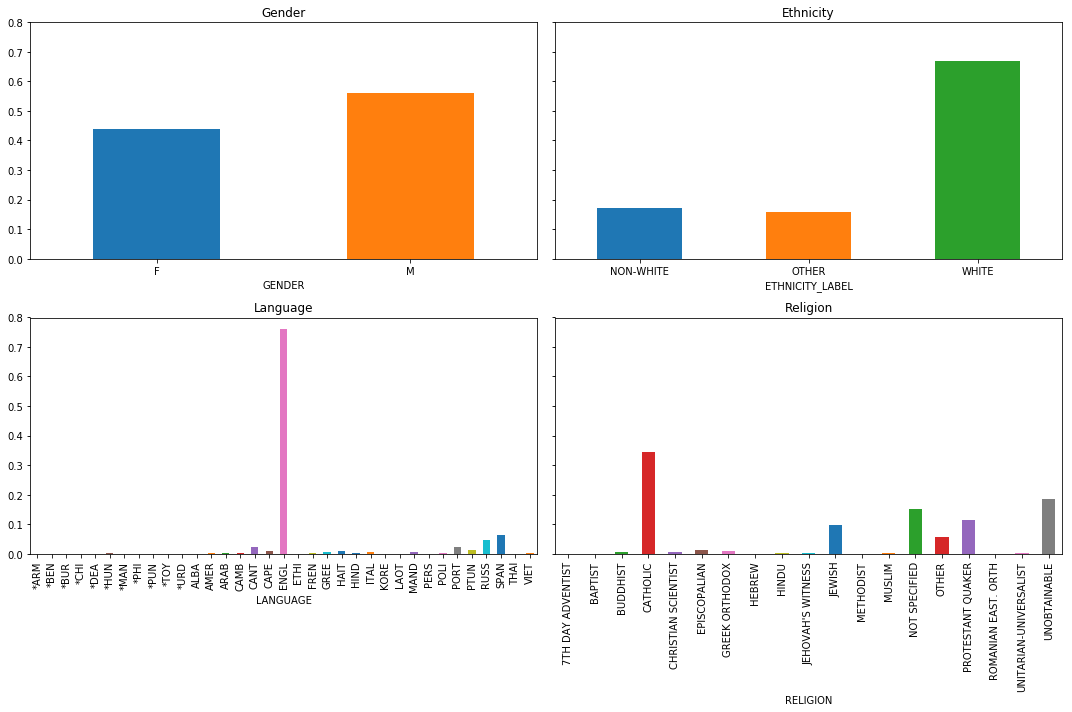

In [149]:
fig, axes = plt.subplots(2,2, sharey=True, figsize=(15,10))
dfg = mini_patients.groupby("GENDER").size()/mini_patients.groupby("GENDER").size().sum()
dfg.plot(ax=axes[0][0],kind="bar", title="Gender",rot=0)

dfe = df_ethnicity.groupby("ETHNICITY_LABEL").size()/df_ethnicity.groupby("ETHNICITY_LABEL").size().sum()
dfe.plot(ax=axes[0][1],kind="bar", title="Ethnicity",rot=0)

dfl = mini_patients.groupby("LANGUAGE").size()/mini_patients.groupby("LANGUAGE").size().sum()
dfl.plot(ax=axes[1][0],kind="bar", title="Language",rot=90)

dfl = mini_patients.groupby("RELIGION").size()/mini_patients.groupby("RELIGION").size().sum()
dfl.plot(ax=axes[1][1],kind="bar", title="Religion",rot=90)
plt.tight_layout()




In [220]:
df_mortality = get_mortality_dataset(mini_patients, out_data_path+"mini_mortality.csv")
df_mortality

,EXPIRE,TEXT
0,0,admission date: [**2149-6-2**] discharg...
1,0,admission date: [**2149-9-2**] discharg...
2,0,admission date: [**2193-1-8**] d...
3,0,admission date: [**2133-9-3**] d...
4,0,admission date: [**2103-8-16**] discharge...
5,0,admission date: [**2196-4-27**] discharge...
6,0,admission date: [**2113-5-10**] discharge...
7,1,admission date: [**2158-1-5**] d...
8,0,admission date: [**2137-4-23**] discharge...
9,0,admission date: [**2191-4-8**] discharge ...


In [221]:
mimic_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
all_admissions = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
all_admissions

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1


In [222]:
df_readm = get_readmissions_dataset(all_admissions, mini_patients, path_out=out_data_path+"/mini_readmissions.csv")
df_readm

,READMISSION,TEXT
0,1,admission date: [**2149-6-2**] discharg...
1,0,admission date: [**2149-9-2**] discharg...
2,0,admission date: [**2193-1-8**] d...
3,1,admission date: [**2133-9-3**] d...
4,0,admission date: [**2103-8-16**] discharge...
5,0,admission date: [**2196-4-27**] discharge...
6,1,admission date: [**2113-5-10**] discharge...
7,0,admission date: [**2158-1-5**] d...
8,0,admission date: [**2137-4-23**] discharge...
9,0,admission date: [**2191-4-8**] discharge ...


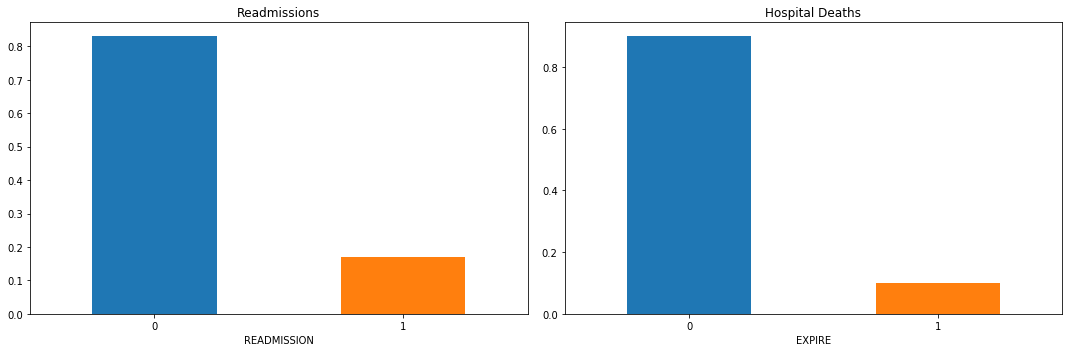

In [223]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_ag = df_readm.groupby("READMISSION").size()/df_readm.groupby("READMISSION").size().sum()
df_ag.plot(ax=ax[0],kind="bar", title="Readmissions", rot=0)

df_mg = df_mortality.groupby("EXPIRE").size()/df_mortality.groupby("EXPIRE").size().sum()
df_mg.plot(ax=ax[1],kind="bar", title="Hospital Deaths", rot=0)
plt.tight_layout()

In [225]:
#subsample majority class (negative)
RATIO = 2
readm_positive_size = df_readm.groupby("READMISSION").size()[1]
mort_positive_size = df_mortality.groupby("EXPIRE").size()[1]

readm_negative_size = int(readm_positive_size * RATIO)
mort_negative_size = int(mort_positive_size * RATIO)

all_readm_size = readm_positive_size + readm_negative_size
all_mort_size = mort_positive_size + mort_negative_size
print("Readmissions > Pos: {}/{} | Neg: {}/{}".format(readm_positive_size,all_readm_size,
                                                      readm_negative_size,all_readm_size))
print("   Mortality > Pos: {}/{} | Neg: {}/{}".format(mort_positive_size,all_mort_size,
                                   mort_negative_size,all_mort_size))

df_readm_neg = df_readm[df_readm["READMISSION"] == 0].head(readm_negative_size)
df_readm_pos = df_readm[df_readm["READMISSION"] == 1]
df_readm_all = df_readm_neg.append(df_readm_pos, ignore_index=True)

df_mortality_neg = df_mortality[df_mortality["EXPIRE"] == 0].head(mort_negative_size)
df_mortality_pos = df_mortality[df_mortality["EXPIRE"] == 1]
df_mortality_all = df_mortality_neg.append(df_mortality_pos, ignore_index=True)

df_mortality_all.to_csv(out_data_path+"/mini_mortality_balanced.csv",index=False, sep="\t", header=False)
df_readm_all.to_csv(out_data_path+"/mini_readmissions_balanced.csv",index=False, sep="\t", header=False)


Readmissions > Pos: 1696/5088 | Neg: 3392/5088
   Mortality > Pos: 1001/3003 | Neg: 2002/3003


## Read Data

In [226]:
df_mortality = pd.read_csv(out_data_path+"mini_mortality_balanced.csv",sep="\t", header=None, names=["EXPIRE","TEXT"])
df_mortality 

,EXPIRE,TEXT
0,0,admission date: [**2149-6-2**] discharg...
1,0,admission date: [**2149-9-2**] discharg...
2,0,admission date: [**2193-1-8**] d...
3,0,admission date: [**2133-9-3**] d...
4,0,admission date: [**2103-8-16**] discharge...
5,0,admission date: [**2196-4-27**] discharge...
6,0,admission date: [**2113-5-10**] discharge...
7,0,admission date: [**2137-4-23**] discharge...
8,0,admission date: [**2191-4-8**] discharge ...
9,0,admission date: [**2100-8-8**] d...


In [227]:
df_readmission = pd.read_csv(out_data_path+"mini_readmissions_balanced.csv",sep="\t", header=None, names=["READMISSION","TEXT"])
df_readmission

,READMISSION,TEXT
0,0,admission date: [**2149-9-2**] discharg...
1,0,admission date: [**2193-1-8**] d...
2,0,admission date: [**2103-8-16**] discharge...
3,0,admission date: [**2196-4-27**] discharge...
4,0,admission date: [**2158-1-5**] d...
5,0,admission date: [**2137-4-23**] discharge...
6,0,admission date: [**2191-4-8**] discharge ...
7,0,admission date: [**2100-8-8**] d...
8,0,admission date: [**2132-12-3**] dischar...
9,0,admission date: [**2150-2-3**] d...


## Analytics

In [251]:
def get_training_data(df, split):
    #split into training and test sets
    train_split, test_split = data.shuffle_split(df, split)
    
    #vectorize instances
    train_X = data.getX(train_split)
    test_X = data.getX(test_split)
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X,_ = vectorizer.docs2idx(test_X, word_vocab)
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y = data.getY(test_split)
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    return train_X, train_Y, test_X, test_Y, word_vocab, label_vocab

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-bin":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-freq":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-bin":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-sum": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    

def evaluate_classifier(X_train, Y_train, X_test, Y_test,
                   labels, model_name, random_seed=1234, res_path=None):
    model = SGDClassifier(random_state=random_seed)
    model.fit(X_train,Y_train)
    Y_hat = model.predict(X_test)
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3), \
            "macroF1":round(macroF1,3)
            }

    for l, i in labels.items():
        res["{}-f1".format(l)] = round(fscore[i],3)
    helpers.print_results(res)
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]
        # helpers.save_results(res, res_path, sep="\t", columns=cols)
        helpers.save_results(res, res_path, sep="\t")
    return res

def run(df, x_label, y_label, feature_type, embeddings_path=None, split=0.8):
    #transform the data into the right format
    dataset = data.read_dataframe(df, x_label, y_label)
    #get vectorized train/test data 
    train_X, train_Y, test_X, test_Y, word_vocab, label_vocab = get_training_data(dataset, split)
    #extract features
    if "BOE" in feature_type:
        assert embeddings_path, "Missing embeddings path"
        #get embeddings     
        E, _ = embeddings.read_embeddings(embeddings_path, word_vocab, "latin-1")
        #get embedding features    
        train_feats = get_features(train_X, len(word_vocab), feature_type, E)
        test_feats = get_features(test_X, len(word_vocab), feature_type, E)
    else:
        train_feats = get_features(train_X, len(word_vocab), feature_type)
        test_feats = get_features(test_X, len(word_vocab), feature_type)

    #train/test classifier for each random seed
    random_seeds = [1,2,3,4,5]
    # random_seeds = [1]
    results = []
    print(label_vocab)
    for r in random_seeds:
        print("[running seed: {}]".format(r))
        res = evaluate_classifier(train_feats, train_Y, test_feats, test_Y, label_vocab, feature_type, r)
        results.append(res)
    return results



In [249]:
df = df_mortality
x_label = "TEXT"
y_label = "EXPIRE"
split=0.8
#split into training and test sets
train_split, test_split = data.shuffle_split_idx(df[y_label], split)
df_train = df.iloc[train_split,:]
df_test = df.iloc[test_split,:]
# df_test_M = df_test[df_test["GENDER"] == "M"]
# df_test_F = df_test[df_test["GENDER"] == "F"]
df_test

,EXPIRE,TEXT
1788,0,admission date: [**2156-1-6**] d...
1974,0,admission date: [**2131-8-23**] dischar...
2837,1,admission date: [**2167-11-30**] ...
1764,0,admission date: [**2167-1-13**] ...
1914,0,admission date: [**2150-2-25**] ...
1620,0,admission date: [**2197-5-26**] ...
2949,1,admission date: [**2133-11-16**] ...
1738,0,admission date: [**2189-2-21**] ...
1818,0,admission date: [**2189-7-26**] discharge...
1812,0,admission date: [**2163-1-23**] ...


## Mortality

In [253]:
embeddings_path = "/Users/samir/Dev/resources/embeddings/word_embeddings.txt"
df = df_mortality
x_label = "TEXT"
y_label = "EXPIRE"
results_BOW = run(df, x_label, y_label, "BOW-bin", split=0.8)
results_BOW_freq = run(df, x_label, y_label, "BOW-freq", split=0.8)
results_BOE_bin = run(df, x_label, y_label, "BOE-bin",embeddings_path=embeddings_path, split=0.8)
results_BOE_sum = run(df, x_label, y_label, "BOE-sum",embeddings_path=embeddings_path, split=0.8)

df_bb = pd.DataFrame(results_BOW)
df_bf = pd.DataFrame(results_BOW_freq)
df_boeb = pd.DataFrame(results_BOE_bin)
df_boes = pd.DataFrame(results_BOE_sum)

(sparse BOW)
(sparse BOW)
{0: 0, 1: 1}
[running seed: 1]
** model: BOW-bin| seed: 1| acc: 0.625| microF1: 0.625| macroF1: 0.491| 0-f1: 0.752| 1-f1: 0.231| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.611| microF1: 0.611| macroF1: 0.471| 0-f1: 0.743| 1-f1: 0.199| 
[running seed: 3]
** model: BOW-bin| seed: 3| acc: 0.575| microF1: 0.575| macroF1: 0.508| 0-f1: 0.689| 1-f1: 0.326| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.545| microF1: 0.545| macroF1: 0.511| 0-f1: 0.639| 1-f1: 0.383| 
[running seed: 5]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


** model: BOW-bin| seed: 5| acc: 0.611| microF1: 0.611| macroF1: 0.458| 0-f1: 0.746| 1-f1: 0.17| 
(sparse BOW)
(sparse BOW)
{0: 0, 1: 1}
[running seed: 1]
** model: BOW-freq| seed: 1| acc: 0.633| microF1: 0.633| macroF1: 0.479| 0-f1: 0.762| 1-f1: 0.196| 
[running seed: 2]
** model: BOW-freq| seed: 2| acc: 0.658| microF1: 0.658| macroF1: 0.454| 0-f1: 0.788| 1-f1: 0.12| 
[running seed: 3]
** model: BOW-freq| seed: 3| acc: 0.664| microF1: 0.664| macroF1: 0.399| 0-f1: 0.798| 1-f1: 0.0| 
[running seed: 4]
** model: BOW-freq| seed: 4| acc: 0.648| microF1: 0.648| macroF1: 0.415| 0-f1: 0.784| 1-f1: 0.045| 
[running seed: 5]
** model: BOW-freq| seed: 5| acc: 0.517| microF1: 0.517| macroF1: 0.506| 0-f1: 0.578| 1-f1: 0.435| 
86772/94738 (91.59 %) words in vocabulary found no embedding
{0: 0, 1: 1}
[running seed: 1]
** model: BOE-bin| seed: 1| acc: 0.663| microF1: 0.663| macroF1: 0.399| 0-f1: 0.797| 1-f1: 0.0| 
[running seed: 2]
** model: BOE-bin| seed: 2| acc: 0.666| microF1: 0.666| macroF1: 0.4|

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


86772/94738 (91.59 %) words in vocabulary found no embedding
{0: 0, 1: 1}
[running seed: 1]
** model: BOE-sum| seed: 1| acc: 0.394| microF1: 0.394| macroF1: 0.386| 0-f1: 0.315| 1-f1: 0.456| 
[running seed: 2]
** model: BOE-sum| seed: 2| acc: 0.666| microF1: 0.666| macroF1: 0.4| 0-f1: 0.8| 1-f1: 0.0| 
[running seed: 3]
** model: BOE-sum| seed: 3| acc: 0.666| microF1: 0.666| macroF1: 0.4| 0-f1: 0.8| 1-f1: 0.0| 
[running seed: 4]
** model: BOE-sum| seed: 4| acc: 0.611| microF1: 0.611| macroF1: 0.517| 0-f1: 0.73| 1-f1: 0.304| 
[running seed: 5]
** model: BOE-sum| seed: 5| acc: 0.575| microF1: 0.575| macroF1: 0.512| 0-f1: 0.687| 1-f1: 0.337| 


## Results

Text(0.5,1.01,'Results per seed')

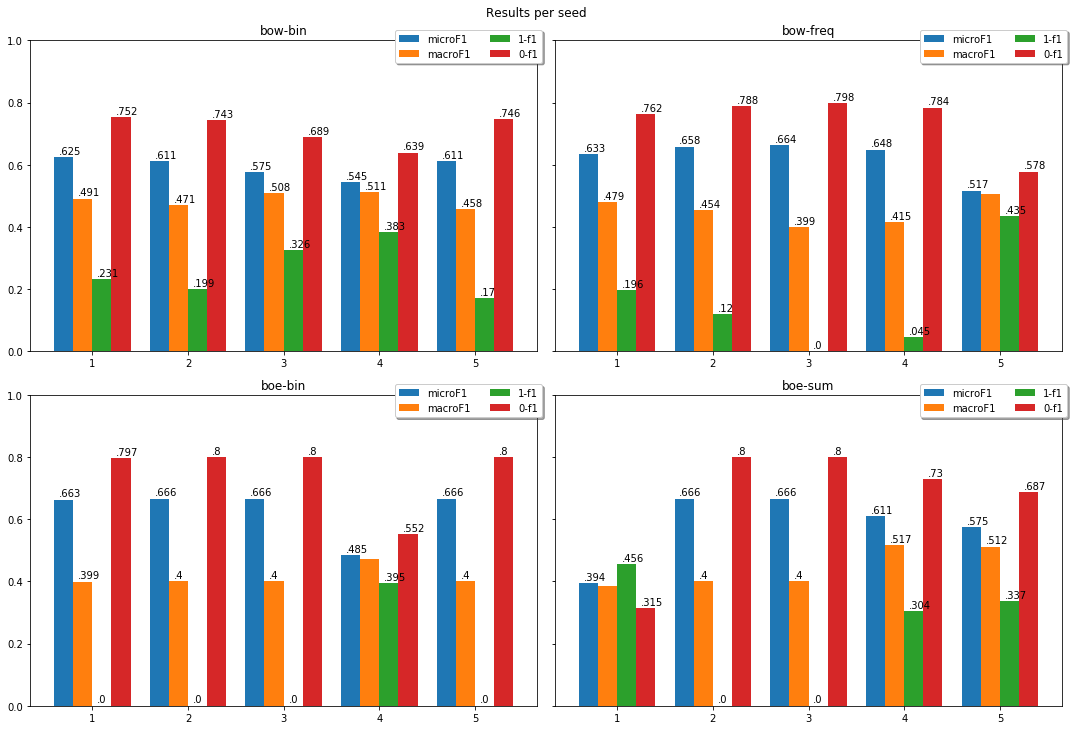

In [233]:
fig, ax = plt.subplots(2,2, sharey=True, figsize=(15,10))

plots.plot_df(df=df_bb,ax=ax[0][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_bf,ax=ax[0][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_boeb,ax=ax[1][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_boes,ax=ax[1][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)


ax[0][0].set_title("bow-bin")
ax[0][1].set_title("bow-freq")
ax[1][0].set_title("boe-bin")
ax[1][1].set_title("boe-sum")
plt.tight_layout()
fig.suptitle("Results per seed",y=1.01)

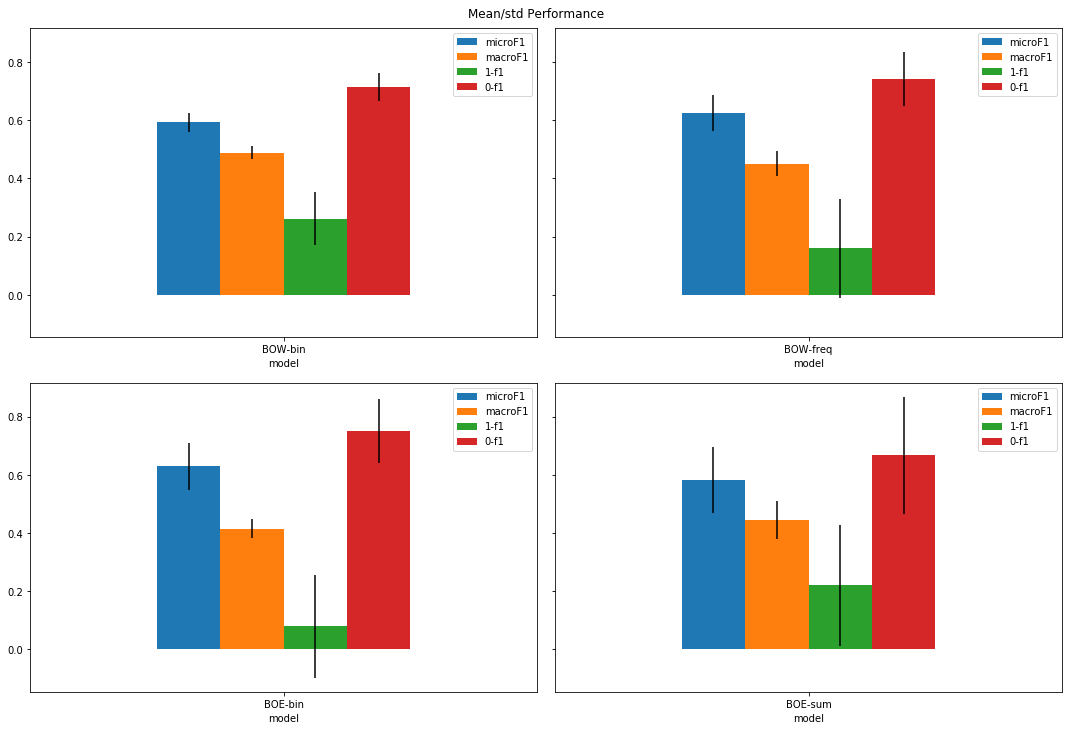

In [234]:
df_bb_mean = df_bb.groupby("model").mean()
df_bb_std = df_bb.groupby("model").std()

df_bf_mean = df_bf.groupby("model").mean()
df_bf_std = df_bf.groupby("model").std()

df_boeb_mean = df_boeb.groupby("model").mean()
df_boeb_std = df_boeb.groupby("model").std()

df_boes_mean = df_boes.groupby("model").mean()
df_boes_std = df_boes.groupby("model").std()

fig2, ax2 = plt.subplots(2,2, sharey=True, figsize=(15,10))

df_bb_mean[["microF1","macroF1","1-f1","0-f1"]].plot(ax=ax2[0][0],legend=True,kind="bar",yerr=df_bb_std, rot=0)
df_bf_mean[["microF1","macroF1","1-f1","0-f1"]].plot(ax=ax2[0][1],legend=True,kind="bar",yerr=df_bf_std, rot=0)
df_boeb_mean[["microF1","macroF1","1-f1","0-f1"]].plot(ax=ax2[1][0],legend=True,kind="bar",yerr=df_boeb_std, rot=0)
df_boes_mean[["microF1","macroF1","1-f1","0-f1"]].plot(ax=ax2[1][1],legend=True,kind="bar",yerr=df_boes_std, rot=0)

fig2.suptitle("Mean/std Performance",y=1.01)
plt.tight_layout()

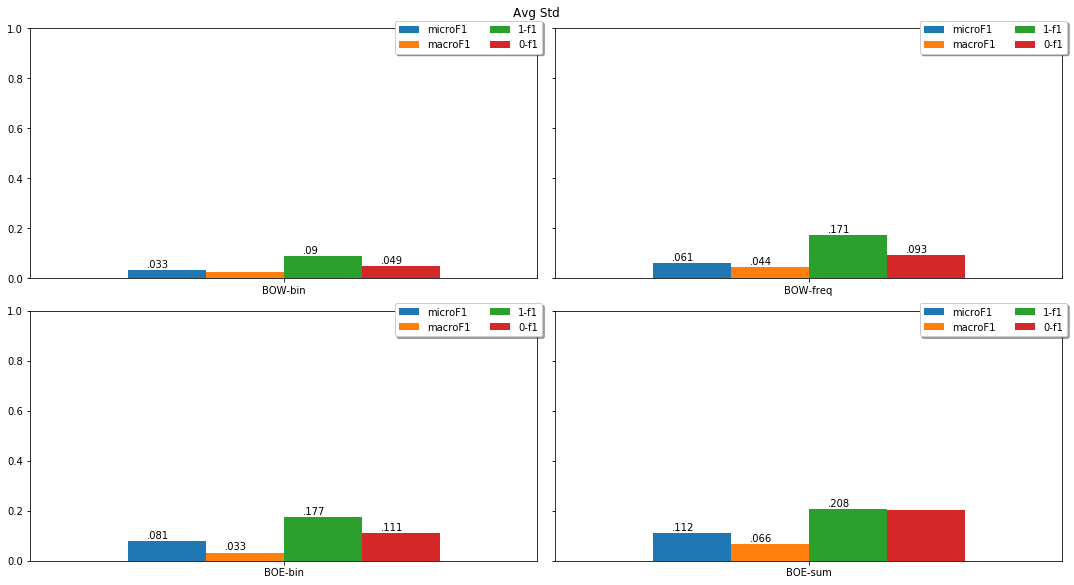

In [235]:
fig3, ax3 = plt.subplots(2,2, sharey=True, figsize=(15,8))

plots.plot_df(df=df_bb_std.reset_index(),ax=ax3[0][0],x="model",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_bf_std.reset_index(),ax=ax3[0][1],x="model",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_boeb_std.reset_index(),ax=ax3[1][0],x="model",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_boes_std.reset_index(),ax=ax3[1][1],x="model",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
fig3.suptitle("Avg Std",y=1.01)
plt.tight_layout()

## Readmissions

In [236]:
embeddings_path = "/Users/samir/Dev/resources/embeddings/word_embeddings.txt"
df = df_readmission
x_label = "TEXT"
y_label = "READMISSION"
results_BOW = run(df, x_label, y_label, "BOW-bin", split=0.8)
results_BOW_freq = run(df, x_label, y_label, "BOW-freq", split=0.8)
results_BOE_bin = run(df, x_label, y_label, "BOE-bin",embeddings_path=embeddings_path, split=0.8)
results_BOE_sum = run(df, x_label, y_label, "BOE-sum",embeddings_path=embeddings_path, split=0.8)


df_bb = pd.DataFrame(results_BOW)
df_bf = pd.DataFrame(results_BOW_freq)
df_boeb = pd.DataFrame(results_BOE_bin)
df_boes = pd.DataFrame(results_BOE_sum)

(sparse BOW)
(sparse BOW)
{0: 0, 1: 1}
[running seed: 1]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


** model: BOW-bin| seed: 1| acc: 0.613| microF1: 0.613| macroF1: 0.52| 0-f1: 0.732| 1-f1: 0.309| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.574| microF1: 0.574| macroF1: 0.522| 0-f1: 0.68| 1-f1: 0.364| 
[running seed: 3]
** model: BOW-bin| seed: 3| acc: 0.639| microF1: 0.639| macroF1: 0.491| 0-f1: 0.765| 1-f1: 0.217| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.634| microF1: 0.634| macroF1: 0.464| 0-f1: 0.766| 1-f1: 0.162| 
[running seed: 5]
** model: BOW-bin| seed: 5| acc: 0.59| microF1: 0.59| macroF1: 0.522| 0-f1: 0.702| 1-f1: 0.343| 
(sparse BOW)
(sparse BOW)
{0: 0, 1: 1}
[running seed: 1]
** model: BOW-freq| seed: 1| acc: 0.652| microF1: 0.652| macroF1: 0.461| 0-f1: 0.782| 1-f1: 0.14| 
[running seed: 2]
** model: BOW-freq| seed: 2| acc: 0.604| microF1: 0.604| macroF1: 0.478| 0-f1: 0.734| 1-f1: 0.223| 
[running seed: 3]
** model: BOW-freq| seed: 3| acc: 0.671| microF1: 0.671| macroF1: 0.45| 0-f1: 0.799| 1-f1: 0.102| 
[running seed: 4]
** model: BOW-freq| seed: 4|

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


131481/140639 (93.49 %) words in vocabulary found no embedding
{0: 0, 1: 1}
[running seed: 1]
** model: BOE-sum| seed: 1| acc: 0.665| microF1: 0.665| macroF1: 0.4| 0-f1: 0.799| 1-f1: 0.0| 
[running seed: 2]
** model: BOE-sum| seed: 2| acc: 0.669| microF1: 0.669| macroF1: 0.412| 0-f1: 0.801| 1-f1: 0.023| 
[running seed: 3]
** model: BOE-sum| seed: 3| acc: 0.666| microF1: 0.666| macroF1: 0.4| 0-f1: 0.8| 1-f1: 0.0| 
[running seed: 4]
** model: BOE-sum| seed: 4| acc: 0.666| microF1: 0.666| macroF1: 0.403| 0-f1: 0.8| 1-f1: 0.006| 
[running seed: 5]
** model: BOE-sum| seed: 5| acc: 0.666| microF1: 0.666| macroF1: 0.405| 0-f1: 0.799| 1-f1: 0.012| 


## Results

Text(0.5,1.01,'Results per seed')

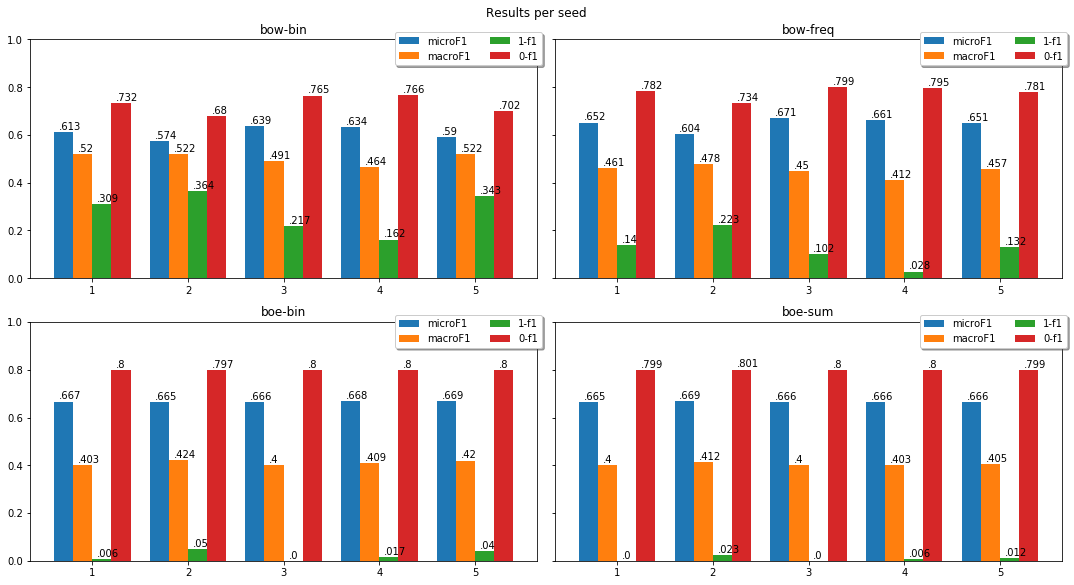

In [237]:
fig, ax = plt.subplots(2,2, sharey=True, figsize=(15,8))

plots.plot_df(df=df_bb,ax=ax[0][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_bf,ax=ax[0][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_boeb,ax=ax[1][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_boes,ax=ax[1][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)


ax[0][0].set_title("bow-bin")
ax[0][1].set_title("bow-freq")
ax[1][0].set_title("boe-bin")
ax[1][1].set_title("boe-sum")
plt.tight_layout()
fig.suptitle("Results per seed",y=1.01)

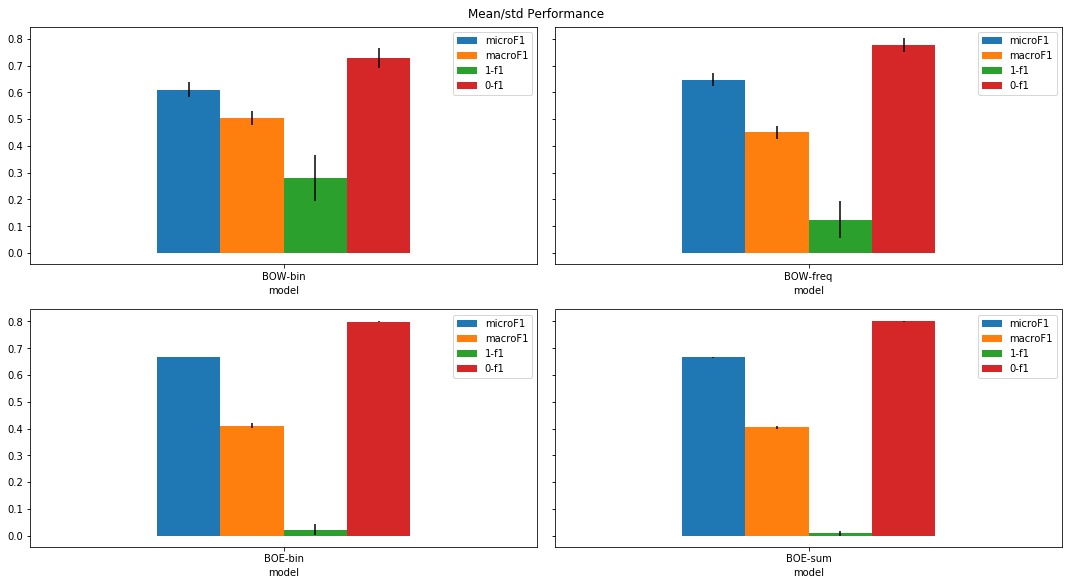

In [238]:
df_bb_mean = df_bb.groupby("model").mean()
df_bb_std = df_bb.groupby("model").std()
df_bf_mean = df_bf.groupby("model").mean()
df_bf_std = df_bf.groupby("model").std()
df_boeb_mean = df_boeb.groupby("model").mean()
df_boeb_std = df_boeb.groupby("model").std()
df_boes_mean = df_boes.groupby("model").mean()
df_boes_std = df_boes.groupby("model").std()

fig2, ax2 = plt.subplots(2,2, sharey=True, figsize=(15,8))

df_bb_mean[["microF1","macroF1","1-f1","0-f1"]].plot(ax=ax2[0][0],legend=True,kind="bar",yerr=df_bb_std, rot=0)
df_bf_mean[["microF1","macroF1","1-f1","0-f1"]].plot(ax=ax2[0][1],legend=True,kind="bar",yerr=df_bf_std, rot=0)
df_boeb_mean[["microF1","macroF1","1-f1","0-f1"]].plot(ax=ax2[1][0],legend=True,kind="bar",yerr=df_boeb_std, rot=0)
df_boes_mean[["microF1","macroF1","1-f1","0-f1"]].plot(ax=ax2[1][1],legend=True,kind="bar",yerr=df_boes_std, rot=0)

fig2.suptitle("Mean/std Performance",y=1.01)
plt.tight_layout()


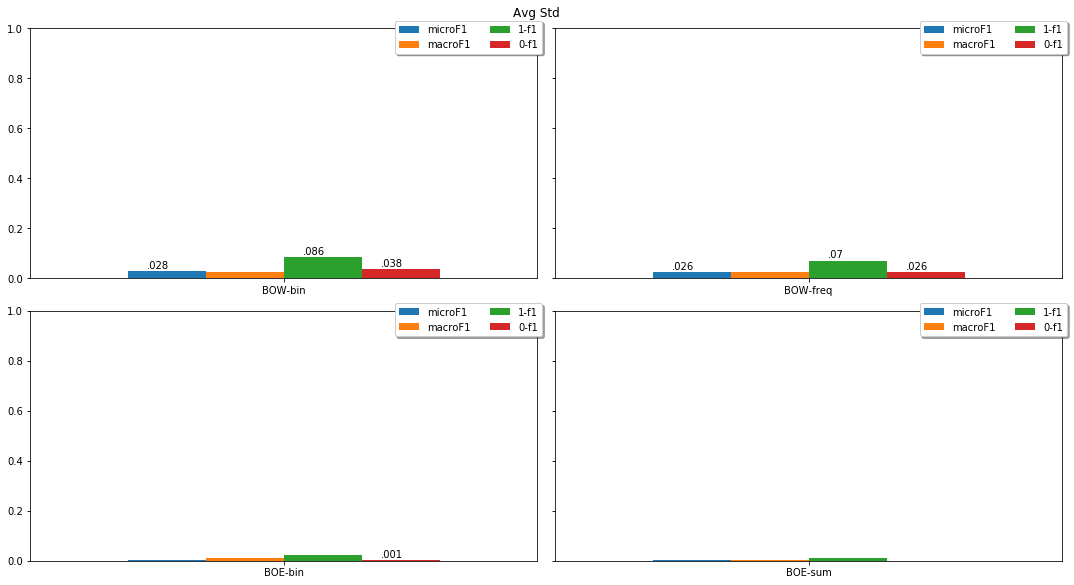

In [240]:
fig3, ax3 = plt.subplots(2,2, sharey=True, figsize=(15,8))

plots.plot_df(df=df_bb_std.reset_index(),ax=ax3[0][0],x="model",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_bf_std.reset_index(),ax=ax3[0][1],x="model",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_boeb_std.reset_index(),ax=ax3[1][0],x="model",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
plots.plot_df(df=df_boes_std.reset_index(),ax=ax3[1][1],x="model",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10)
fig3.suptitle("Avg Std",y=1.01)
plt.tight_layout()